# Import all the modules

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Read dataset and get basic info about it

In [2]:
df = pd.read_csv('movie_dataset.csv')
df.columns 

Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'director'],
      dtype='object')

In [3]:
df.describe()

,index,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.000000,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2401.000000,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,1386.651002,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1200.500000,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,2401.000000,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,3601.500000,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,4802.000000,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


Histogram of continous numerical variable 

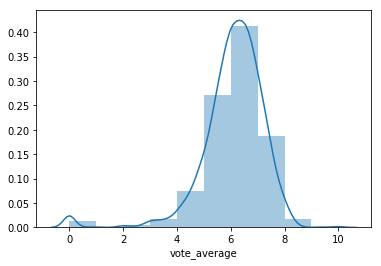

In [23]:
sns.distplot(df.vote_average, bins=10)

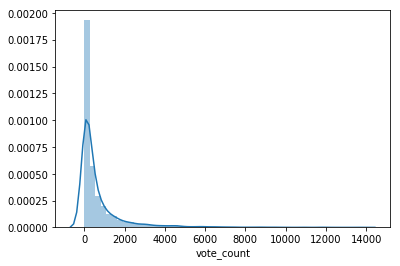

In [27]:
sns.distplot(df.vote_count, bins=50)

# Popularity Based Filtering

Use weighted rank to construct a new score about movie rating

weighted rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

 where:
  R = average for the movie (mean) = (Rating)
  v = number of votes for the movie = (votes)
  m = minimum votes required to be listed in the Top 250
  C = the mean vote across the whole report

In [5]:
C = df['vote_average'].mean()
m = df['vote_count'].quantile(0.9)
df_score = df.copy().loc[df['vote_count'] >= m]

def weighted_rating(x, C=C, m=m):
    R = x['vote_average']
    v = x['vote_count']
    return (v / (v+m)) * R + (m / (v+m)) * C

df_score['score'] = df_score.apply(weighted_rating, axis=1)
# Sort the score value by descending
df_score = df_score.sort_values('score', ascending=False)
df_score[['title', 'vote_average', 'vote_count', 'score']].head(10)

,title,vote_average,vote_count,score
1881,The Shawshank Redemption,8.5,8205,8.059258
662,Fight Club,8.3,9413,7.939256
65,The Dark Knight,8.2,12002,7.920020
3232,Pulp Fiction,8.3,8428,7.904645
96,Inception,8.1,13752,7.863239
3337,The Godfather,8.4,5893,7.851236
95,Interstellar,8.1,10867,7.809479
809,Forrest Gump,8.2,7927,7.803188
329,The Lord of the Rings: The Return of the King,8.1,8064,7.727243
1990,The Empire Strikes Back,8.2,5879,7.697884


Text(0.5, 1.0, 'First 10 movies sorted by Score')

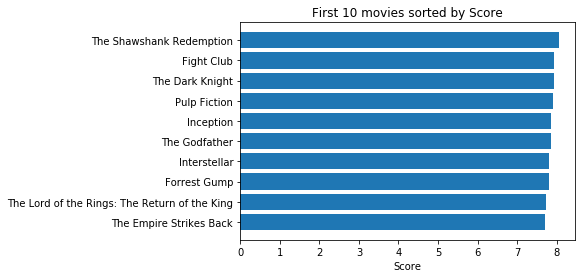

In [11]:
plt.barh(df_score.title.head(10), df_score.score.head(10), align='center')
plt.gca().invert_yaxis()
plt.xlabel('Score')
plt.title('First 10 movies sorted by Score')

Or simply sort popularity score 

In [6]:
df_pop = df.sort_values('popularity', ascending=False)
df_pop[['title', 'popularity']].head(10)

,title,popularity
546,Minions,875.581305
95,Interstellar,724.247784
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564
28,Jurassic World,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,271.972889
82,Dawn of the Planet of the Apes,243.791743
200,The Hunger Games: Mockingjay - Part 1,206.227151
88,Big Hero 6,203.734590


Text(0.5, 1.0, 'First 10 movies sorted by Popularity')

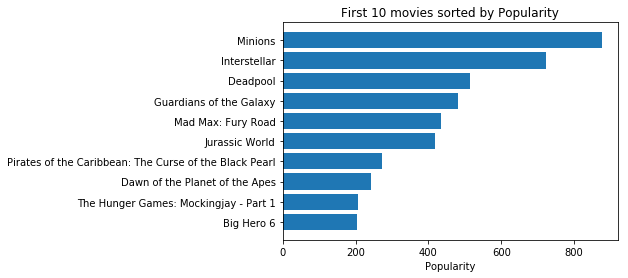

In [12]:
plt.barh(df_pop.title.head(10), df_pop.popularity.head(10), align='center')
plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.title('First 10 movies sorted by Popularity')

# Content Based FIltering

Import the modules needed

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

Check if there is any missing value

In [14]:
tfidf = TfidfVectorizer(stop_words='english')
df['overview'].isna().values.any()

True

In [15]:
df['overview'] = df['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df['overview'])
tfidf_matrix.shape

(4803, 20978)

In [16]:
# Calculate cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(4803, 4803)

For a given movie, write a function to get recommendations of top 10 movies

In [17]:
def content_based_recommend(title):
    ind = df[df['title'] == title].index[0]
    lst = list(enumerate(cosine_sim[ind]))
    sim_score = sorted(lst, key=lambda x: x[1], reverse=True)
    movie_ind = [i[0] for i in sim_score[1:11]]

    return df['title'].iloc[movie_ind]

# Output a recommendation of users who have watched 'Avatar'
content_based_recommend('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title, dtype: object

Or we can use metadata based filtering. This is another type of content based filtering.

In [18]:
# Import modules 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
# Check if there is any missing value
features = ['keywords', 'cast', 'genres', 'director']
df[features].isna().values.any()

True

In [20]:
for feature in features:
    df[feature] = df[feature].fillna('')

In [21]:
# Focus on the four features 'keywords', 'cast', 'genres', 'director'
# Combine these four as a new feature 
def get_combined_variable(row):
    return row['keywords'] + ' ' + row['cast'] + ' ' + row['genres'] + ' ' + row['director']

df['combined_feature'] = df.apply(get_combined_variable, axis=1)
df['combined_feature'].head()

0    culture clash future space war space colony so...
1    ocean drug abuse exotic island east india trad...
2    spy based on novel secret agent sequel mi6 Dan...
3    dc comics crime fighter terrorist secret ident...
4    based on novel mars medallion space travel pri...
Name: combined_feature, dtype: object

In [22]:
# Build a new feature vector 
# Get new cosine similarity score

cv = CountVectorizer(stop_words='english')
count_matrix = cv.fit_transform(df['combined_feature'])
cosine_sim = cosine_similarity(count_matrix)

# Output a recommendation for users who have watched 'Avatar'
content_based_recommend('Avatar')

94              Guardians of the Galaxy
2403                             Aliens
3208    Star Wars: Clone Wars: Volume 1
47              Star Trek Into Darkness
56                     Star Trek Beyond
3158                              Alien
2696                            Jason X
2198                            Lockout
4401                The Helix... Loaded
1053                       Galaxy Quest
Name: title, dtype: object